# Models (sepsis-pics)


## Common


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


In [2]:
SEED = 1011
CV_FOLDS = 3
cv = StratifiedKFold(
    n_splits=CV_FOLDS,
    shuffle=True,
    random_state=SEED,
)


In [3]:
df_result = pd.DataFrame(index=['AUC mean', 'AUC std'])

def record_result(name, auc_mean, auc_std):
    df_result[name] = [auc_mean, auc_std]


In [4]:
def plot_roc_file(title, input_path, auc_mean, auc_std):

    df_roc = pd.read_csv(input_path, sep='\t')
    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot()

    ax.set_title(title)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')

    t = [0, 1]
    ax.plot(
        t,
        t,
        '--',
        c='lightgray',
        label='chance level (AUC = 0.5)',
    )

    x = df_roc['FPR']
    y = df_roc['TPR']
    ax.plot(
        x,
        y,
        'b-',
        label=fr'ROC (AUC = {auc_mean:.2f} $\pm$ {auc_std:.2f})',
    )

    ax.legend(loc='lower right')


In [5]:
def test_sklearn(name, model, scoring='roc_auc'):
    '''
    Test the given model.

    Parameters
    ----------
    name : str
        Model name.
    model : scikit-learn compact model
        The model to test.
    scoring : str, default='roc_auc'
        The scoring method.
    '''

    scores = cross_val_score(
        model,
        X,
        y,
        cv=cv,
        scoring=scoring,
    )

    auc_mean = scores.mean()
    auc_std = scores.std()
    record_result(name, auc_mean, auc_std)

    print(f'>>> CV Result ({name}, {scoring})')
    print(f'Scores: {scores}')
    print(f'  Mean: {auc_mean:.4f}')
    print(f'   Std: {auc_std:.4f}')


## Prepare Data


In [6]:
df_data = pd.read_csv(
    './data_eicu_compact_pics.csv',
    index_col='patientunitstayid',
)

# remove entries with -1
mask_neg1 = (df_data == -1.0).any(axis='columns')
df_data = df_data[~mask_neg1]

df_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2193 entries, 242505 to 3351713
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          2193 non-null   float64
 1   urine        2193 non-null   float64
 2   wbc          2193 non-null   float64
 3   meanbp       2193 non-null   float64
 4   vasopressor  2193 non-null   int64  
 5   hr           2193 non-null   float64
 6   creatinine   2193 non-null   float64
 7   platelet     2193 non-null   float64
 8   inr          2193 non-null   float64
 9   pt           2193 non-null   float64
 10  ptt          2193 non-null   float64
 11  lactate      2193 non-null   float64
 12  rdw          2193 non-null   float64
 13  bilirubin    2193 non-null   float64
 14  bicarbonate  2193 non-null   float64
 15  pics         2193 non-null   bool   
dtypes: bool(1), float64(14), int64(1)
memory usage: 276.3 KB


<AxesSubplot:>

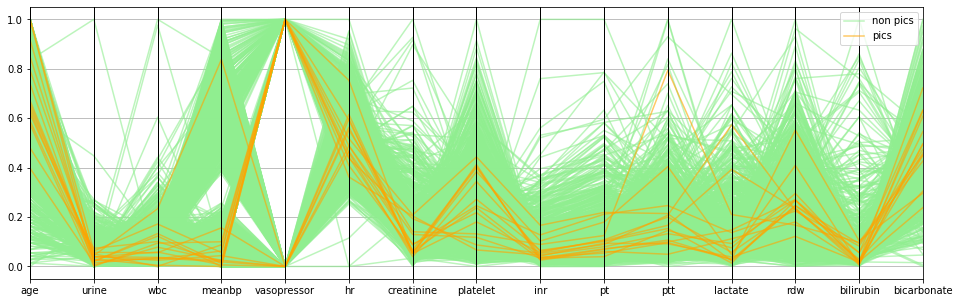

In [32]:
df_visualize = df_data.copy()

# map labels
df_visualize['pics'] = df_visualize['pics'].map(
    lambda v: 'pics' if v else 'non pics'
)

# map data to [0, 1]
for col in df_visualize.columns[:-1]:
    maximum = df_visualize[col].max()
    minimum = df_visualize[col].min()
    delta = maximum - minimum
    df_visualize[col] = (df_visualize[col] - minimum) / delta

# visualize input data
fig_visualize = plt.figure(figsize=(16, 5))
ax_visualize = fig_visualize.add_subplot()
pd.plotting.parallel_coordinates(
    df_visualize.sort_values(by='pics'),
    'pics',
    color=['lightgreen', 'orange'],
    alpha=0.6,
    ax=ax_visualize,
)


In [8]:
X = df_data.drop(columns=['pics'])
y = df_data['pics'] \
    .map(int) \
    .to_numpy() \
    .ravel()


In [9]:
X


,age,urine,wbc,meanbp,vasopressor,hr,creatinine,platelet,inr,pt,ptt,lactate,rdw,bilirubin,bicarbonate
patientunitstayid,,,,,,,,,,,,,,,
242505,90.0,2189.5488,9.6,55.0,0,95.0,1.385714,155.800000,1.000000,13.900000,38.000000,1.200000,17.580000,0.766667,20.857143
243629,87.0,1156.2912,7.1,47.0,1,103.0,1.460000,131.250000,1.500000,17.933333,79.900000,1.950000,15.475000,0.800000,23.200000
244763,47.0,939.6000,2.9,129.0,0,121.0,0.600000,118.666667,1.000000,13.200000,34.000000,1.200000,14.250000,0.500000,27.777778
245906,73.0,5.0976,23.2,171.0,1,114.0,5.590000,154.900000,1.040000,14.000000,30.400000,2.000000,16.310000,0.200000,23.500000
246013,66.0,1055.4624,0.6,61.0,0,84.0,1.070000,40.833333,1.040000,14.100000,25.700000,2.525000,17.916667,0.300000,18.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3349260,62.0,2590.4448,12.6,56.0,1,93.0,0.618824,388.142857,1.045000,10.600000,26.000000,1.900000,14.435714,1.850000,29.176471
3350924,53.0,378.8640,4.9,74.0,0,101.0,0.760714,248.142857,1.115000,11.350000,22.000000,1.366667,14.907143,0.300000,36.214286
3351255,75.0,80.4384,23.0,42.0,1,86.0,2.520000,63.000000,1.340000,14.400000,42.666667,4.050000,15.400000,0.633333,18.800000


In [10]:
y


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [11]:
total_count = len(y)
pos_count = y.sum()
neg_count = total_count - pos_count
coefficient_neg = pos_count / total_count
coefficient_pos = 1 - coefficient_neg
weight_neg = coefficient_neg / neg_count
weight_pos = coefficient_pos / pos_count
weights = [
    weight_pos if v == 1 else weight_neg
    for v in y
]

print(f'  weight_pos = {weight_pos:.6f}')
print(f'  weight_neg = {weight_neg:.6f}')
print(f'sum(weights) = {sum(weights):.6f}')


  weight_pos = 0.066211
  weight_neg = 0.000003
sum(weights) = 1.000000


## CatBoost


In [13]:
from catboost import CatBoostClassifier

catboost_model = CatBoostClassifier(
    random_state=SEED,
    verbose=False,
)

test_sklearn(
    'CatBoost',
    catboost_model,
)


>>> CV Result (CatBoost, roc_auc)
Scores: [0.59944904 0.66143251 0.62561983]
  Mean: 0.6288
   Std: 0.0254


## Light Gradient Boosting


In [16]:
from lightgbm import LGBMClassifier

lgb_model = LGBMClassifier(
    boosting_type='goss',
    # is_unbalance=True,  # worse
    random_state=SEED,
)

test_sklearn(
    'LightGB',
    lgb_model,
)


>>> CV Result (LightGB, roc_auc)
Scores: [0.56721763 0.48016529 0.51404959]
  Mean: 0.5205
   Std: 0.0358


## Extreme Gradient Boosting


In [17]:
from xgboost import XGBClassifier

xgboost_model = XGBClassifier(
    booster='gblinear',
    updater='coord_descent',
    feature_selector='greedy',
    random_state=SEED,
)

test_sklearn(
    'XGBoost',
    xgboost_model,
)


>>> CV Result (XGBoost, roc_auc)
Scores: [0.60523416 0.7415978  0.60247934]
  Mean: 0.6498
   Std: 0.0649


## Gradient Boosting


In [18]:
from sklearn.ensemble import GradientBoostingClassifier

gradient_boosting_model = GradientBoostingClassifier()

test_sklearn(
    'GradientBoosting',
    gradient_boosting_model,
)


>>> CV Result (GradientBoosting, roc_auc)
Scores: [0.41735537 0.62272727 0.54077135]
  Mean: 0.5270
   Std: 0.0844


## Extra Trees


In [19]:
from sklearn.ensemble import ExtraTreesClassifier

extra_trees_model = ExtraTreesClassifier(
    class_weight='balanced',
)

test_sklearn(
    'ExtraTrees',
    extra_trees_model,
)


>>> CV Result (ExtraTrees, roc_auc)
Scores: [0.58044077 0.45027548 0.70454545]
  Mean: 0.5784
   Std: 0.1038


## Ridge Classifier


In [20]:
from sklearn.linear_model import RidgeClassifier

ridge_model = RidgeClassifier(
    # class_weight='balanced',  # worse...
)

test_sklearn(
    'Ridge',
    ridge_model,
)


>>> CV Result (Ridge, roc_auc)
Scores: [0.67493113 0.64903581 0.56143251]
  Mean: 0.6285
   Std: 0.0486


## Logistic Regression


In [21]:
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression(
    solver='newton-cholesky',
    # class_weight='balanced',  # worse...
)

test_sklearn(
    'Logistic',
    logistic_model,
)


>>> CV Result (Logistic, roc_auc)
Scores: [0.66942149 0.60192837 0.62341598]
  Mean: 0.6316
   Std: 0.0282


## K-Nearest Neighbors


In [22]:
from sklearn.neighbors import KNeighborsClassifier

neighbors_model = KNeighborsClassifier()

test_sklearn(
    'KNeighbors',
    neighbors_model,
)


>>> CV Result (KNeighbors, roc_auc)
Scores: [0.47589532 0.48209366 0.48966942]
  Mean: 0.4826
   Std: 0.0056


## AdaBoost


In [23]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_model = AdaBoostClassifier()

test_sklearn(
    'AdaBoost',
    adaboost_model,
)


>>> CV Result (AdaBoost, roc_auc)
Scores: [0.84325069 0.47024793 0.59807163]
  Mean: 0.6372
   Std: 0.1548


## Linear Discriminant Analysis


In [24]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_model = LinearDiscriminantAnalysis()

test_sklearn(
    'LDA',
    lda_model,
)


>>> CV Result (LDA, roc_auc)
Scores: [0.67493113 0.64876033 0.56088154]
  Mean: 0.6282
   Std: 0.0488


## MLP


In [25]:
from sklearn.neural_network import MLPClassifier

mlp_model = make_pipeline(
    StandardScaler(),
    MLPClassifier(
        hidden_layer_sizes=(100,),
        max_iter=1000,
    ),
)

test_sklearn(
    'MLP',
    mlp_model,
)


>>> CV Result (MLP, roc_auc)
Scores: [0.43526171 0.50550964 0.56721763]
  Mean: 0.5027
   Std: 0.0539


## Decision Tree


In [26]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_model = DecisionTreeClassifier(
    class_weight='balanced',
)

test_sklearn(
    'DecisionTree',
    decision_tree_model,
)


>>> CV Result (DecisionTree, roc_auc)
Scores: [0.49449036 0.49586777 0.49449036]
  Mean: 0.4949
   Std: 0.0006


## SVM (With RBF Kernel)


In [27]:
from sklearn.svm import SVC

svm_model = make_pipeline(
    StandardScaler(),
    SVC(
        kernel='rbf',  # default
    ),
)

test_sklearn(
    'SVM',
    svm_model,
)


>>> CV Result (SVM, roc_auc)
Scores: [0.31101928 0.52865014 0.36528926]
  Mean: 0.4017
   Std: 0.0925


## Naive Bayes


In [28]:
from sklearn.naive_bayes import ComplementNB

nb_model = ComplementNB()

test_sklearn(
    'NaiveBayes',
    nb_model,
)


>>> CV Result (NaiveBayes, roc_auc)
Scores: [0.50055096 0.62796143 0.48250689]
  Mean: 0.5370
   Std: 0.0647


## Summary


In [35]:
df_summary = df_result.T.sort_values(
    by='AUC mean',
    ascending=False,
)

df_summary.style.format('{:.4f}')


,AUC mean,AUC std
XGBoost,0.6498,0.0649
AdaBoost,0.6372,0.1548
Logistic,0.6316,0.0282
CatBoost,0.6288,0.0254
Ridge,0.6285,0.0486
LDA,0.6282,0.0488
ExtraTrees,0.5784,0.1038
NaiveBayes,0.5370,0.0647
GradientBoosting,0.5270,0.0844
LightGB,0.5205,0.0358


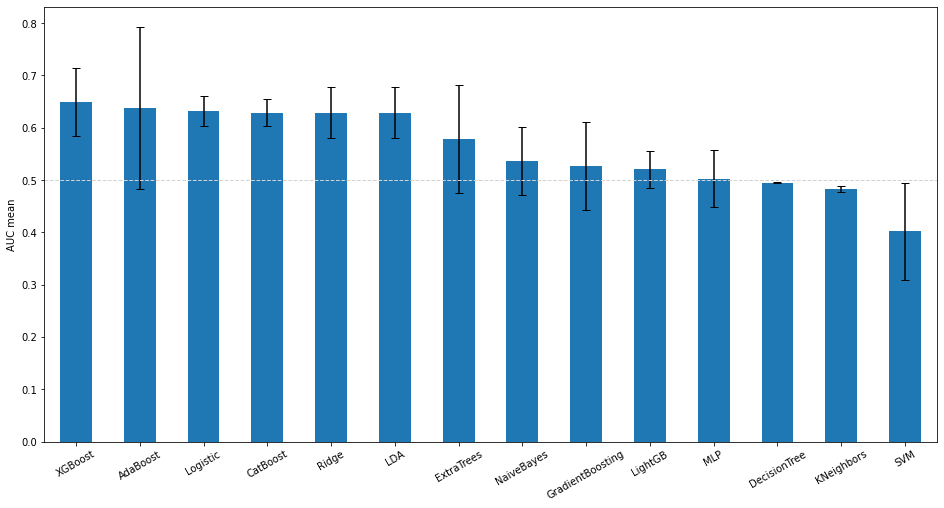

In [36]:
fig_summary = plt.figure(figsize=(16, 8))
ax_summary = fig_summary.add_subplot()

df_summary['AUC mean'].plot.bar(
    yerr=df_summary['AUC std'],
    ax=ax_summary,
    capsize=4,
)

ax_summary.set_ylabel('AUC mean')
ax_summary.axhline(y=0.5, c='lightgray', ls='--', lw=1)

# adjust x labels
for label in ax_summary.get_xticklabels():
    label.set_rotation(30)
